<a href="https://colab.research.google.com/github/jcampuzano1111/K-Means-/blob/main/K_Means_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

sns.set(style="whitegrid", context="talk")

plt.rcParams["font.size"] = 12          # base font size
plt.rcParams["axes.titlesize"] = 14     # title font
plt.rcParams["axes.labelsize"] = 12     # x/y label font
plt.rcParams["xtick.labelsize"] = 10    # x tick labels
plt.rcParams["ytick.labelsize"] = 10    # y tick labels
plt.rcParams["legend.fontsize"] = 10    # legend

df = pd.read_csv("/content/drive/MyDrive/Collab/K-Means/ecommerce_customer_behavior_dataset_v2.csv")

# Customer Segmentation with K-Means

This notebook performs customer segmentation using K-Means clustering on an e-commerce dataset.  
We:

1. Load and inspect the raw order-level data.
2. Aggregate it to the customer level.
3. Engineer behavioral/value features (RFM-style).
4. Standardize the features.
5. Apply K-Means to discover customer segments.
6. Profile and interpret each segment from a business perspective.


In [2]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df.head()

,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,Total_Amount,Payment_Method,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating
0,ORD_000001-1,CUST_00001,2023-05-29,40,Male,Ankara,Books,29.18,1,0.00,29.18,Digital Wallet,Mobile,14,9,True,13,4
1,ORD_000001-2,CUST_00001,2023-10-12,40,Male,Ankara,Home & Garden,644.40,1,138.05,506.35,Credit Card,Desktop,14,8,True,6,2
2,ORD_000001-3,CUST_00001,2023-12-05,40,Male,Ankara,Sports,332.82,5,0.00,"1,664.10",Credit Card,Mobile,15,10,True,9,4
3,ORD_000002-1,CUST_00002,2023-05-11,33,Male,Istanbul,Food,69.30,5,71.05,275.45,Digital Wallet,Desktop,16,13,True,4,4
4,ORD_000002-2,CUST_00002,2023-06-16,33,Male,Istanbul,Beauty,178.15,3,0.00,534.45,Credit Card,Mobile,14,7,True,6,4


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17049 entries, 0 to 17048
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Order_ID                  17049 non-null  object        
 1   Customer_ID               17049 non-null  object        
 2   Date                      17049 non-null  datetime64[ns]
 3   Age                       17049 non-null  int64         
 4   Gender                    17049 non-null  object        
 5   City                      17049 non-null  object        
 6   Product_Category          17049 non-null  object        
 7   Unit_Price                17049 non-null  float64       
 8   Quantity                  17049 non-null  int64         
 9   Discount_Amount           17049 non-null  float64       
 10  Total_Amount              17049 non-null  float64       
 11  Payment_Method            17049 non-null  object        
 12  Device_Type       

In [4]:
cust = df.groupby("Customer_ID").agg(
    # Static / demographic info
    Age=("Age", "first"),
    Gender=("Gender", "first"),
    City=("City", "first"),
    Device_Type=("Device_Type", lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0]),

    # Behavioral flags
    is_returning=("Is_Returning_Customer", "max"),

    # Monetary / frequency
    n_orders=("Order_ID", "nunique"),
    total_spent=("Total_Amount", "sum"),
    avg_order_value=("Total_Amount", "mean"),
    avg_rating=("Customer_Rating", "mean"),

    # Timing
    first_purchase=("Date", "min"),
    last_purchase=("Date", "max")
).reset_index()

# Customer lifetime (inclusive, in days)
cust["customer_lifetime_days"] = (cust["last_purchase"] - cust["first_purchase"]).dt.days + 1
cust["customer_lifetime_days"] = cust["customer_lifetime_days"].fillna(0)

# Convert boolean to numeric 0/1 for modeling
cust["is_returning"] = cust["is_returning"].astype(int)

cust.head()


,Customer_ID,Age,Gender,City,Device_Type,is_returning,n_orders,total_spent,avg_order_value,avg_rating,first_purchase,last_purchase,customer_lifetime_days
0,CUST_00001,40,Male,Ankara,Mobile,1,3,"2,199.63",733.21,3.33,2023-05-29,2023-12-05,191
1,CUST_00002,33,Male,Istanbul,Desktop,1,2,809.90,404.95,4.00,2023-05-11,2023-06-16,37
2,CUST_00003,42,Male,Konya,Desktop,1,2,"3,030.81","1,515.40",3.50,2023-02-27,2024-01-03,311
3,CUST_00004,53,Male,Izmir,Desktop,0,1,383.22,383.22,5.00,2024-02-13,2024-02-13,1
4,CUST_00005,32,Male,Ankara,Mobile,1,3,"2,422.73",807.58,3.67,2023-03-16,2023-06-21,98


In [5]:
cust.describe()[["total_spent", "n_orders", "avg_order_value", "customer_lifetime_days"]]


,total_spent,n_orders,avg_order_value,customer_lifetime_days
count,"5,000.00","5,000.00","5,000.00","5,000.00"
mean,"4,355.81",3.41,"1,262.89",196.77
min,14.28,1.00,14.28,1.00
25%,889.41,2.00,387.12,52.00
50%,"2,493.93",3.00,794.48,210.00
75%,"5,796.30",5.00,"1,550.70",320.00
max,"50,628.15",10.00,"25,314.08",448.00
std,"5,274.55",2.18,"1,539.04",141.11


In [6]:
seg_features = [
    "total_spent",
    "n_orders",
    "avg_order_value",
    "customer_lifetime_days",
    "is_returning",
    "avg_rating"
]

X_seg = cust[seg_features].copy()
X_seg.head()


,total_spent,n_orders,avg_order_value,customer_lifetime_days,is_returning,avg_rating
0,"2,199.63",3,733.21,191,1,3.33
1,809.90,2,404.95,37,1,4.00
2,"3,030.81",2,"1,515.40",311,1,3.50
3,383.22,1,383.22,1,0,5.00
4,"2,422.73",3,807.58,98,1,3.67


In [7]:
scaler = StandardScaler()
X_seg_scaled = scaler.fit_transform(X_seg)

X_seg_scaled[:5]


array([[-0.40883062, -0.18784999, -0.34419487, -0.04089926,  0.27392997,
        -0.75096076],
       [-0.67233554, -0.64624431, -0.55750511, -1.13233999,  0.27392997,
         0.12930201],
       [-0.25123165, -0.64624431,  0.16409186,  0.80957404,  0.27392997,
        -0.53089507],
       [-0.75323779, -1.10463864, -0.57162572, -1.38748198, -3.65056812,
         1.44969617],
       [-0.36652891, -0.18784999, -0.29586985, -0.70001607,  0.27392997,
        -0.31082938]])

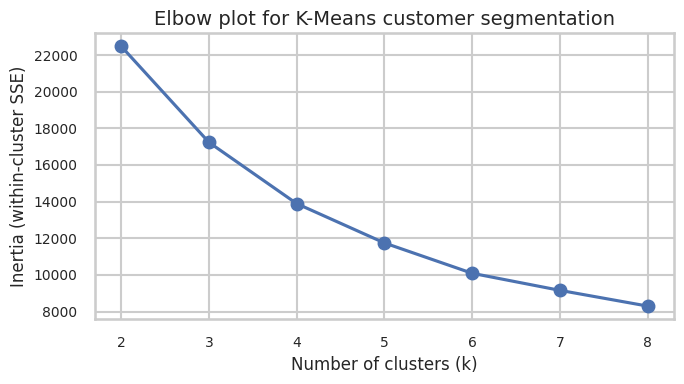

In [8]:
inertias = []
k_values = range(2, 9)  # try 2 to 8 clusters

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_seg_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow plot for K-Means customer segmentation")
plt.xticks(k_values)
plt.tight_layout()
plt.show()


In [9]:
k_opt = 4  # adjust after inspecting elbow plot

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
cust["segment"] = kmeans.fit_predict(X_seg_scaled)

cust["segment"].value_counts().sort_index()


,count
segment,
0,1908
1,2339
2,343
3,410


In [10]:
seg_profile = cust.groupby("segment")[seg_features].mean().round(2)
seg_size = cust["segment"].value_counts().rename("n_customers")

seg_summary = seg_profile.join(seg_size)
seg_summary


,total_spent,n_orders,avg_order_value,customer_lifetime_days,is_returning,avg_rating,n_customers
segment,,,,,,,
0,"5,417.33",5.20,"1,056.78",327.70,1.00,3.91,1908
1,"1,811.91",2.16,841.46,112.73,1.00,3.89,2339
2,967.23,1.00,967.23,1.00,0.00,3.94,343
3,"16,763.34",4.23,"4,873.56",230.69,0.99,3.91,410


In [11]:
seg_median = cust.groupby("segment")[seg_features].median().round(2)
seg_median


,total_spent,n_orders,avg_order_value,customer_lifetime_days,is_returning,avg_rating
segment,,,,,,
0,"4,750.69",5.00,929.24,336.00,1.00,4.00
1,"1,219.59",2.00,554.43,104.00,1.00,4.00
2,426.73,1.00,426.73,1.00,0.00,4.00
3,"15,685.24",3.00,"4,110.28",253.00,1.00,4.00


In [12]:
demo_cols = ["Gender", "City", "Device_Type"]

seg_demo = cust.groupby("segment")[demo_cols].agg(
    lambda x: x.value_counts().index[0]  # most frequent value
)

seg_demo


,Gender,City,Device_Type
segment,,,
0,Female,Istanbul,Mobile
1,Female,Istanbul,Mobile
2,Male,Istanbul,Mobile
3,Male,Istanbul,Mobile


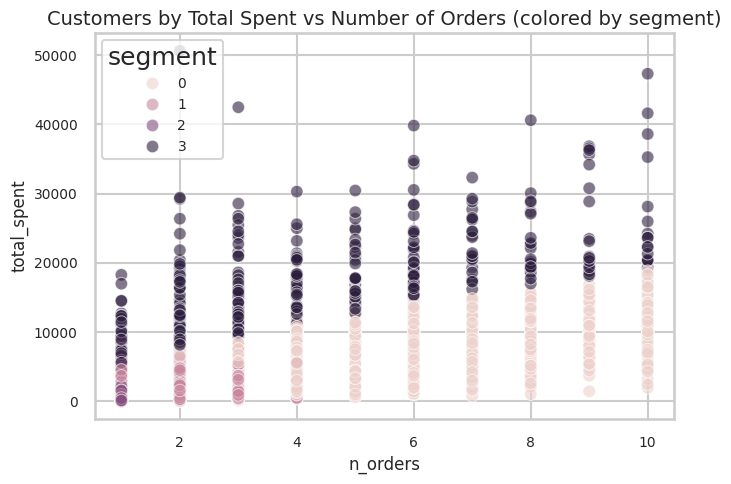

In [13]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=cust,
    x="n_orders",
    y="total_spent",
    hue="segment",
    alpha=0.6
)
plt.title("Customers by Total Spent vs Number of Orders (colored by segment)")
plt.tight_layout()
plt.show()


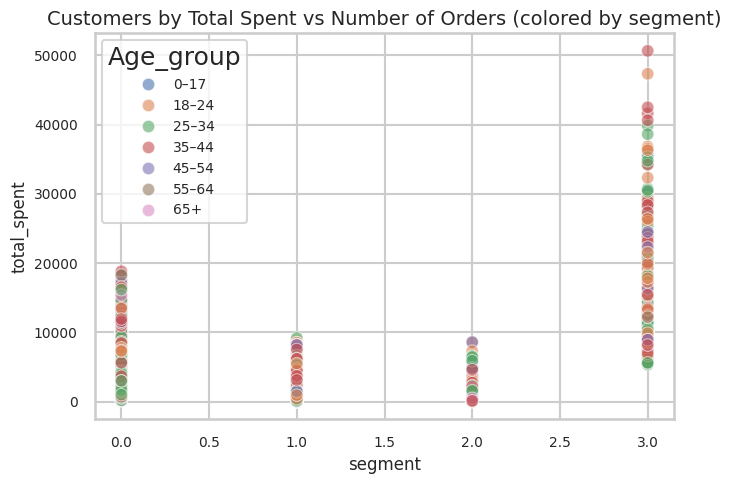

In [16]:
bins = [0, 17, 24, 34, 44, 54, 64, 100]
labels = ["0–17", "18–24", "25–34", "35–44", "45–54", "55–64", "65+"]

cust["Age_group"] = pd.cut(cust["Age"], bins=bins, labels=labels, right=True, include_lowest=True)


cust[["Age", "Age_group"]]
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=cust,
    x="segment",
    y="total_spent",
    hue="Age_group",
    alpha=0.6
)
plt.title("Customers by Total Spent vs Number of Orders (colored by segment)")
plt.tight_layout()
plt.show()

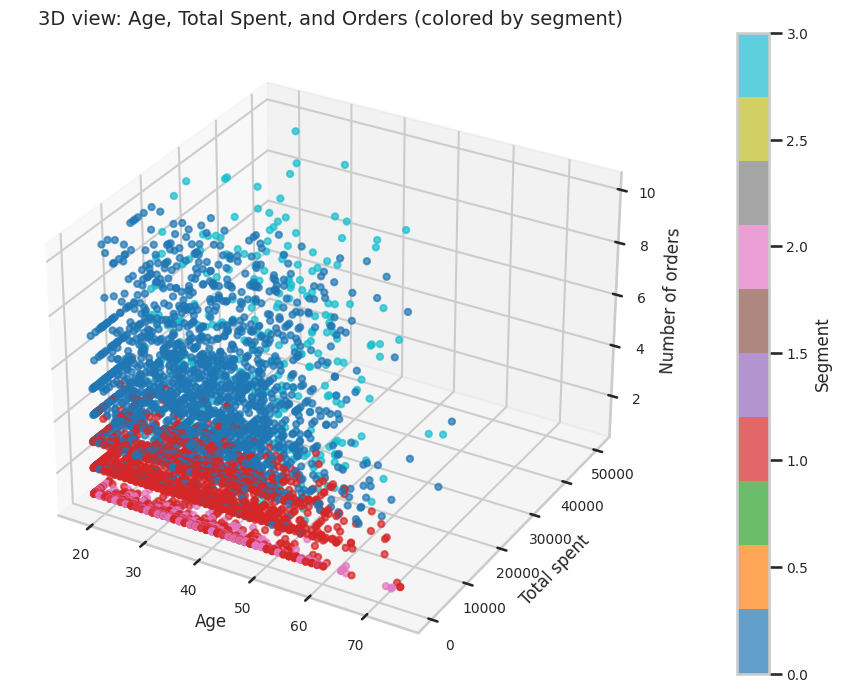

In [17]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    cust["Age"],          # X: Age
    cust["total_spent"],  # Y: Total spent
    cust["n_orders"],     # Z: Number of orders
    c=cust["segment"],    # color by segment
    cmap="tab10",         # discrete colormap (good for segments)
    alpha=0.7
)

ax.set_xlabel("Age")
ax.set_ylabel("Total spent")
ax.set_zlabel("Number of orders")

plt.title("3D view: Age, Total Spent, and Orders (colored by segment)")
fig.tight_layout()

# Optional: colorbar for segments
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Segment")

plt.show()



In [18]:
cust.columns

Index(['Customer_ID', 'Age', 'Gender', 'City', 'Device_Type', 'is_returning',
       'n_orders', 'total_spent', 'avg_order_value', 'avg_rating',
       'first_purchase', 'last_purchase', 'customer_lifetime_days', 'segment',
       'Age_group'],
      dtype='object')

In [19]:
# If you don't have plotly installed yet, run this once:
# !pip install plotly

import plotly.express as px

# Make sure these columns exist in `cust`:
# - "Age"
# - "total_spent"
# - "n_orders"
# - "segment"

# Optional: treat segment as categorical for nicer colors
cust["segment"] = cust["segment"].astype(str)

fig = px.scatter_3d(
    cust,
    x="Age",               # X-axis
    y="total_spent",       # Y-axis
    z="n_orders",          # Z-axis
    color="segment",       # Color by segment
    hover_name="Customer_ID",  # What to show as main label on hover (optional)
    hover_data={
        "City": True,
        "Device_Type": True,
        "Age": True,
        "total_spent": True,
        "n_orders": True,
        "segment": True,
    }
)

fig.update_layout(
    title="Interactive 3D: Age vs Total Spent vs Number of Orders (colored by segment)",
    scene=dict(
        xaxis_title="Age",
        yaxis_title="Total spent",
        zaxis_title="Number of orders"
    )
)

fig.show()




## Segment Interpretation

Based on K-Means clustering (k = 4), we identify four customer segments:

- **Segment 0 – Loyal High-Spend Regulars**  
  - High total spend (~4,750), around 5 orders, lifetime ~11 months.  
  - Almost all are returning customers with good ratings.  
  - Business view: core VIP regulars to retain and reward via loyalty programs and personalized offers.

- **Segment 1 – Emerging Valuable Customers**  
  - Medium total spend (~1,220), 2 orders, lifetime ~3–4 months.  
  - Returning customers with healthy order values and good ratings.  
  - Business view: growth-potential customers to nurture toward Segment 0 with upsell/engagement campaigns.

- **Segment 2 – One-Time / Trial Customers**  
  - Single order (~427), lifetime = 1 day, non-returning.  
  - Good rating but no repeat purchase.  
  - Business view: new or churn-prone customers; key target for reactivation and second-purchase campaigns.

- **Segment 3 – Big-Ticket VIPs**  
  - Very high total spend (~15,685), only 3 orders but extremely high AOV (~4,110).  
  - Long lifetime (~8 months), returning customers with good ratings.  
  - Business view: big-ticket VIPs who warrant premium treatment, exclusive benefits, and exceptional service.

